In [6]:
%matplotlib inline
import ncstudy.analysis as analysis
import numpy as np
import pdb
import time
import matplotlib.pyplot as plt
import matplotlib

In [92]:
def filter_spikeTime_signalState(spikeTime, time, signal, state):
    '''
    Filter spike time that occur during a chosen signal state.
    
    Arguments:
    
        spikeTime (float) : post-synaptic spike time
        time (np.array)   : array of time bins
        signal (np.array) : signal states over time
        state  (int)      : chosen state of signal
    
    Returns:
        spikeTime_in_state (bool) : boolean to signal whether spikeTime occurred during a given signal state.
    '''
    
    return signal[spikeTime>=time][-1] == state

def filter_spikeTime_nonZeroCount(spikeTime, time, preSpikeCounts):
    '''
    Filter spike time that occur during non-zero presynaptic spike counts.
    
    Arguments:
        spikeTime (float)         : post-synaptic spike time
        time (np.array)           : array of time bins
        preSpikeCounts (np.array) : pre synaptic spike counts
        
    Returns:
        spikeTime_in_nonzero (bool) : boolean to signal whether spikeTime occurred during nonzero spike count
        
    '''
    return get_spikeTime_preCount(spikeTime, time, preSpikeCounts) > 0
    
def get_spikeTime_preCount(spikeTime, time, preSpikeCounts):
    return preSpikeCounts[spikeTime>=time][-1]

def generate_pseudopopulation(cells, celltype='NF', codetype='rate', signal_state=None, response_win='all'):
    '''
    Generate a pseudo-population of spike trains for a given cell type, stimulus type, and response window
    
    Arguments:
        cells (CellCollection)      : CellCollection containing recorded cells and corresponding results
        celltype (string)           : desired cell type (default = NF). Options = ('NF', 'PV', 'SST')
        codetype (string)           : desired stimulus code type (default = 'rate'). Options = ('rate', 'temp')
        signal_state (None or int)  : desired stimulus code state (default = None). Options = (None, 0, 1)
        response_win (string)       : desired response window (default = 'all'). Options = ('all', 'mono', 'poly')
        
    Returns:
        pseudopop_spikeTimes (list) : spike times for pseudopopulation
        pseudopop_phases (list)     : spike phases for pseudopopulation
    '''
    
    pseudopop_spikeTimes = []
    pseudopop_phases     = []
    pseudopop_preCounts  = []
    for cell_id, celln in cells.items():
        if celltype in celln.fluor:
            if celln.layer == 'L2/3' and celln.syns.reliability >= 0.9:
                try:
                    #pdb.set_trace()
                    spikeTimes = getattr(celln, '%s_code'%codetype).spikeTimes[response_win]
                    signal = getattr(celln, '%s_code'%codetype).signal.astype('int')
                    counts = getattr(celln, '%s_code'%codetype).stimulus.sum(axis=1).astype('int')
                    time   = getattr(celln, '%s_code'%codetype).time
                    trial_id = np.random.randint(len(spikeTimes))
                    spikeTimes = spikeTimes[trial_id]
                    if signal_state is not None:
                        spikeTimes = filter(lambda s : filter_spikeTime_signalState(s, time, signal, signal_state), spikeTimes)
                    spikeTimes = filter(lambda s : filter_spikeTime_nonZeroCount(s, time, counts), spikeTimes)
                    preCounts  = [get_spikeTime_preCount(s, time, counts) for s in spikeTimes]
                    
                except AttributeError:
                    continue
                
                except IndexError:
                    print('%s_%s_%s'%(cell_id, codetype, trial_id))
                    break
                
                pseudopop_spikeTimes.append(spikeTimes)
                
                pseudopop_phases.append(spikeTimes_to_phase(np.array(spikeTimes), frequency=20))
                
                pseudopop_preCounts.append(preCounts)
    return pseudopop_spikeTimes, pseudopop_phases, pseudopop_preCounts

def spikeTimes_to_phase(spikeTimes, frequency):
    '''
    Convert spike times to phases with respect to a given frequency
    
    Arguments:
        spike times (np.array) : array of spike times for a particular cell in a particular trial
        frequency (float)      : desired frequency to obtain phases
    
    Returns:
        phases (np.array)      : array of phases
        
    '''
    dt = 1./frequency
    phase = 2*np.pi*(spikeTimes%dt)/dt
    return phase

def pi_tick_labels(nticks = 7):
    '''
    Return ticks and tick labels in the bound of [0, 2 pi]
    
    Arguments :
        nticks (int) : number of ticks
    
    Returns :
        ticks (np.array)   : tick locations
        tick_labels (list) : list of strings containing tick labels
    '''
    
    from fractions import Fraction
    tick_labels = ['0']
    for ix in range(1, nticks):
        F = Fraction(2*ix, nticks-1)
        num = F.numerator
        den = F.denominator
        tick_string = r'$\pi$'
        if num > 1:
            tick_string = r'%i'%num + tick_string
        if den > 1:
            tick_string = tick_string + r'/%i'%den
        tick_labels.append(tick_string)
        
    ticks = np.linspace(0, 2*np.pi, nticks)
    return ticks, tick_labels

In [100]:
Ps, Pp, Pc = generate_pseudopopulation(A.cells, celltype='NF', codetype='rate', signal_state=1, response_win='all');

In [101]:
np.unique(Pc[0], return_counts=True)

(array([1, 2, 3, 4, 5, 6]), array([ 23, 106, 149,  77,  53,  22]))

In [47]:
def generate_popn_vector_distributions(n, cells,celltype,codetype,signal_state,response_win):
    
    vector_length = []
    
    for n in range(n):
    
        spk_times, spk_phases = generate_pseudopopulation(
            cells, celltype=celltype, codetype=codetype, signal_state=signal_state, 
            response_win=response_win)
        
        # calculating population synchrony vector 
        Vij = [[np.sin(phase), np.cos(phase)] for phase in spk_phases];
        popn_vector = np.nansum([[np.nanmean(r), np.nanmean(c)] for r,c in Vij], axis=0)/len(Vij)#/np.sum([len(phase) for phase in spk_phases])

        # find radial distance, r, of synchrony vector 
        r_val = np.linalg.norm(popn_vector)
                
        vector_length.append(r_val)
        
    return vector_length

/Users/matt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: Mean of empty slice


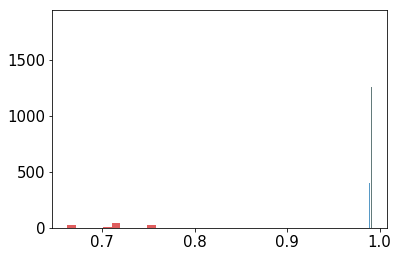

In [49]:
vect_len_all = generate_popn_vector_distributions(100, A.cells, celltype='PV',codetype='temp',signal_state=None,response_win='mono')
vect_len_mono_low = generate_popn_vector_distributions(100, A.cells, celltype='PV',codetype='temp',signal_state=0,response_win='mono')
vect_len_mono_high = generate_popn_vector_distributions(100, A.cells, celltype='PV',codetype='temp',signal_state=1,response_win='mono')

plt.hist(vect_len_all,color='darkslategray', histtype='stepfilled', alpha=0.75, density=True)
plt.hist(vect_len_mono_low,color='C3', histtype='stepfilled', alpha=0.75, density=True)
plt.hist(vect_len_mono_high,color='C0', histtype='stepfilled', alpha=0.75, density=True)

plt.savefig('pseudopopn_vector_distribution_PV_rate_mono'+(time.strftime("%d-%m-%Y-%H-%M-%S"))+'.svg')

plt.show()

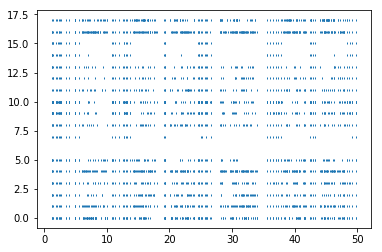

In [4]:
# generate pseudopopulation and plot raster
Ps, Pp = generate_pseudopopulation(A.cells, celltype='NF', codetype='temp')
for cellnum, spikeTimes in enumerate(Ps):
    plt.plot(spikeTimes, cellnum*np.ones_like(spikeTimes), '|', ms=2, color='C0')

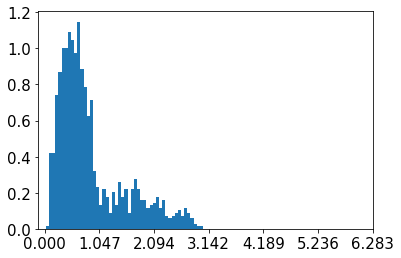

In [267]:
# generate histogram of spk phases

#plt.hist(np.concatenate(Pp), bins=50, density=True)
#plt.xticks(np.linspace(0, 2*np.pi, 7), pi_tick_labels(7));

plt.hist(np.concatenate(Pp), bins=50, density=True)
plt.xticks(np.linspace(0, 2*np.pi, 7))
plt.savefig('pseudopopn_spk_histogram_SST_rate'+(time.strftime("%d-%m-%Y-%H-%M-%S"))+'.svg')

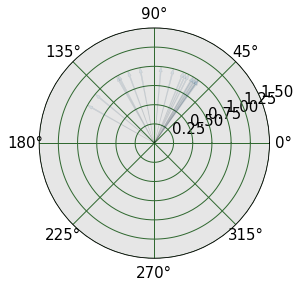

[0.69969083 0.09894736] 0.8218569149192877 0.3294551493540683


In [295]:
#plot sample polar plot for individual cell

Vij = [[np.sin(phase), np.cos(phase)] for phase in Pp]
popn_vector = np.sum([[np.sum(r),np.sum(c)] for r,c in Vij], axis=0)/np.sum([len(phase) for phase in Pp])

# find radial distance, r, of cell vector 
r_val = np.linalg.norm(popn_vector)

# find vector angle, theta, 
vect_angle = np.arctan((popn_vector[1]/popn_vector[0]))

#### Plot Spike times in Unit Vector on Polar Coordinates ####

# radar green, solid grid lines
plt.rc('grid', color='#316931', linewidth=1, linestyle='-')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# force square figure and square axes looks better for polar, IMO
width, height = matplotlib.rcParams['figure.figsize']
size = min(width, height)
# make a square figure
fig = plt.figure(figsize=(size, size))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True, facecolor='#E6E6E6')

r = np.arange(0, 3.0, 0.01)
theta = 2*np.pi*r
#ax.plot(theta, r, color='#ee8d18', lw=3)
ax.set_rmax(1.5)
plt.grid(True)

# plot each individual spike time

for i in range(len(Pp[0])):
    arr1 = plt.arrow(Pp[0][i], 0, 0, 1, alpha = 0.1, width = 0.015,
                     edgecolor = 'black', lw = 0.5, zorder = 5, length_includes_head=True)

plt.savefig('pseudopopn_spk_ind_polarplot_SST_temp'+(time.strftime("%d-%m-%Y-%H-%M-%S"))+'.svg')
plt.show()

print vect_mean, r_val, vect_angle

In [310]:
np.arctan?

/Users/matt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


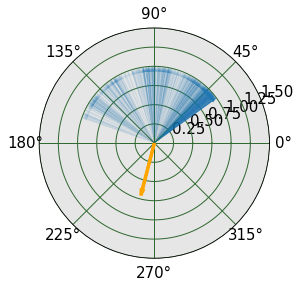

NameError: name 'vect_mean' is not defined

In [9]:
#plot popn polar plot

Vij = [[np.sin(phase), np.cos(phase)] for phase in Pp]
popn_vector = np.nansum([[np.nanmean(r),np.nanmean(c)] for r,c in Vij], axis=0)/len(Vij)#/np.sum([len(phase) for phase in Pp])

# find radial distance, r, of cell vector 
r_val = np.linalg.norm(popn_vector)

# find vector angle, theta, 
vect_angle = np.arctan2(popn_vector[1],popn_vector[0])

#### Plot Spike times in Unit Vector on Polar Coordinates ####

# radar green, solid grid lines
plt.rc('grid', color='#316931', linewidth=1, linestyle='-')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# force square figure and square axes looks better for polar, IMO
width, height = matplotlib.rcParams['figure.figsize']
size = min(width, height)
# make a square figure
fig = plt.figure(figsize=(size, size))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True, facecolor='#E6E6E6')

r = np.arange(0, 3.0, 0.01)
theta = 2*np.pi*r
#ax.plot(theta, r, color='#ee8d18', lw=3)
ax.set_rmax(1.5)
plt.grid(True)

# plot each individual spike time

for i in range(len(Pp)):
    for j in range(len(Pp[i])):
        arr1 = plt.arrow(Pp[i][j], 0, 0, 1, alpha = 0.1, width = 0.015,
                     edgecolor = 'black', lw = 0.0001, zorder = 5, length_includes_head=True)

# plot vector sum of all spike times 
arr2 =  plt.arrow((vect_angle*180/np.pi), 0, 0, r_val, alpha = 1, width = 0.015,
                 edgecolor = 'orange', lw = 3, zorder = 5, length_includes_head=True)

plt.savefig('pseudopopn_spk_popn_polarplot_SST_rate'+(time.strftime("%d-%m-%Y-%H-%M-%S"))+'.svg')
plt.show()

print r_val, vect_angle

In [304]:
Vij

[[array([0.83744288, 0.89377154, 0.63754405, 0.82344419, 0.99611991,
         0.88236457, 0.82344419, 0.81624924, 0.84424442, 0.92501801,
         0.93878755, 0.49286294, 0.91004139, 0.98231644, 0.86384493,
         0.85744648, 0.87026053, 0.9685444 ]),
  array([ 0.54652486,  0.4485225 , -0.7704139 ,  0.56739728,  0.08800643,
         -0.47056644,  0.56739728,  0.57769991,  0.53595836,  0.37992325,
         -0.34449663, -0.87010696,  0.4145174 , -0.18722824,  0.50375782,
          0.51457316, -0.49259173,  0.24884082])],
 [array([0.79729484, 0.80481663, 0.88484579, 0.85384664, 0.87285863,
         0.65120545, 0.59218969, 0.9564707 ]),
  array([0.60359004, 0.59352354, 0.46588404, 0.52052465, 0.48797316,
         0.75890148, 0.80579859, 0.29182838])],
 [array([0.70655187, 0.84726152, 0.67937797, 0.8538694 , 0.78190202,
         0.67010351]),
  array([0.70766125, 0.53117598, 0.73378851, 0.52048732, 0.62340133,
         0.74226766])],
 [array([0.64217198, 0.62270543, 0.59277206, 0.59277206

In [10]:
# calculating population synchrony vector 
Vij = [[np.sin(phase), np.cos(phase)] for phase in Pp2]
np.sum([[np.sum(r),np.sum(c)] for r,c in Vij], axis=0)/np.sum([len(phase) for phase in Pp2])

# need to calculate loop to sample 100x new populations to create distribution of vector lengths 
# need to generate distributions for all cells, low and high 

# sample from that distribution 100x 


array([0.51485896, 0.10839691])

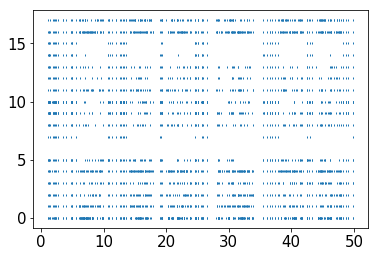

In [168]:
Ps2, Pp2 = generate_pseudopopulation(A.cells, celltype='NF', codetype='temp')
for cellnum, spikeTimes in enumerate(Ps2):
    plt.plot(spikeTimes, cellnum*np.ones_like(spikeTimes), '|', ms=2, color='C0')

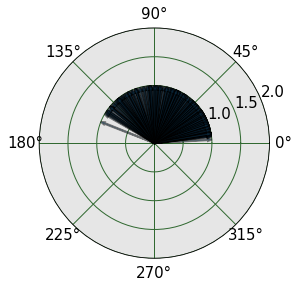

[240.42176082 192.20172263] 307.80533662629284 0.674396721454651


In [410]:
import matplotlib
import matplotlib.pyplot as plt

# find sum of all vectors for sample cell
cell_vect = np.transpose(np.asarray((np.sin(Pp[0]),np.cos(Pp[0]))))
vect_sum = np.sum(vect,axis=0)

# find radial distance, r, of cell vector 
r_val = np.linalg.norm(vect_sum)

# find vector angle, theta, 
vect_angle = np.arctan((vect_sum[1]/vect_sum[0]))


#### Plot Spike times in Unit Vector on Polar Coordinates ####

# radar green, solid grid lines
plt.rc('grid', color='#316931', linewidth=1, linestyle='-')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# force square figure and square axes looks better for polar, IMO
width, height = matplotlib.rcParams['figure.figsize']
size = min(width, height)
# make a square figure
fig = plt.figure(figsize=(size, size))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True, facecolor='#E6E6E6')

r = np.arange(0, 3.0, 0.01)
theta = 2*np.pi*r
#ax.plot(theta, r, color='#ee8d18', lw=3)
ax.set_rmax(2)
plt.grid(True)

# plot each individual spike time
for i in range(len(Pp[0])):
    arr1 = plt.arrow(Pp[0][i], 0, 0, 1, alpha = 0.5, width = 0.015,
                 edgecolor = 'black', lw = 2, zorder = 5, length_includes_head=True)

# plot vector sum of all spike times 
#arr2 =  plt.arrow(vect_angle, 0, 0, r_val, alpha = 1, width = 0.015,
#                 edgecolor = 'orange', lw = 3, zorder = 5, length_includes_head=True)

plt.savefig('individualcell_spktimes.svg')
plt.show()

# Full analysis run for viewing results only

In [3]:
A = analysis.Analysis('./data')
A.run(fig_dir='./figures/manuscript');

  0%|          | 0/94 [00:00<?, ?it/s]

Loading...


  0%|          | 0/94 [00:00<?, ?it/s]

Updating...


/Users/matt/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
ncstudy/stats.py:109: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  pr.append(np.histogram(postSpikes_i, bins=br, normed=True)[0])
100%|██████████| 94/94 [09:22<00:00,  5.18s/it]
ncstudy/plots.py:197: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x = df.select_dtyp

Saving...


100%|██████████| 94/94 [03:53<00:00,  2.46s/it]


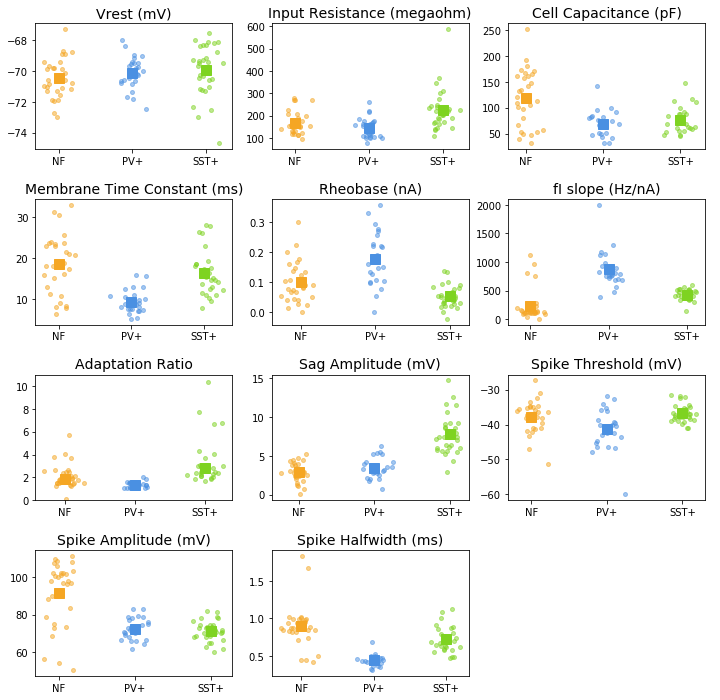

In [6]:
A.fig_ephys

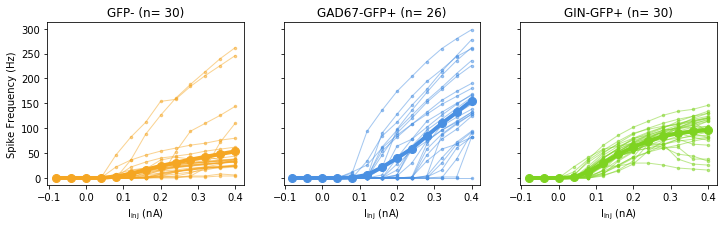

In [38]:
A.fig_fi

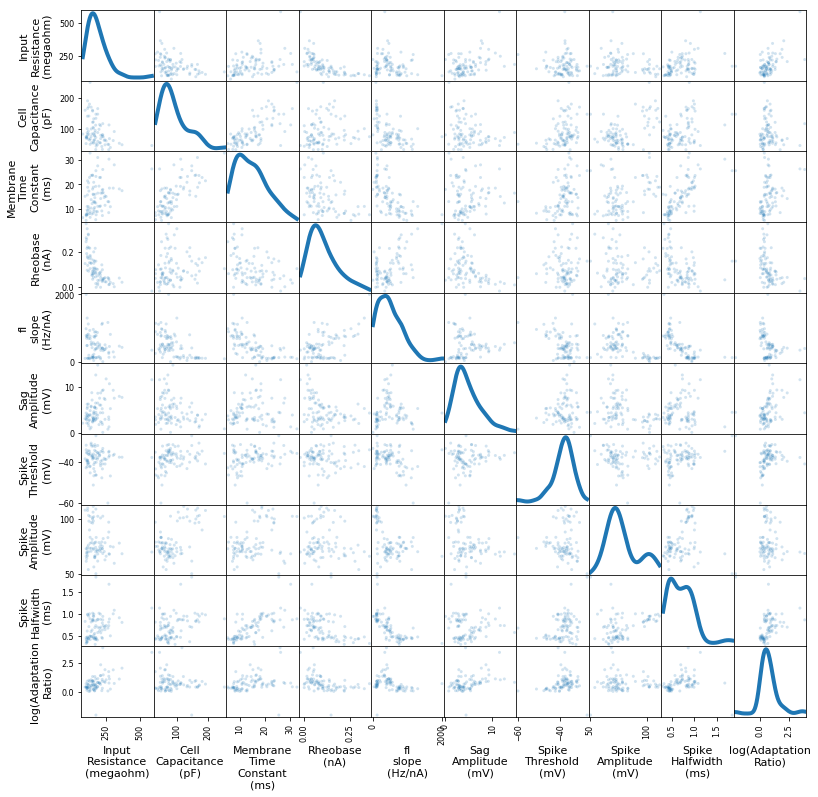

In [6]:
A.fig_scatter

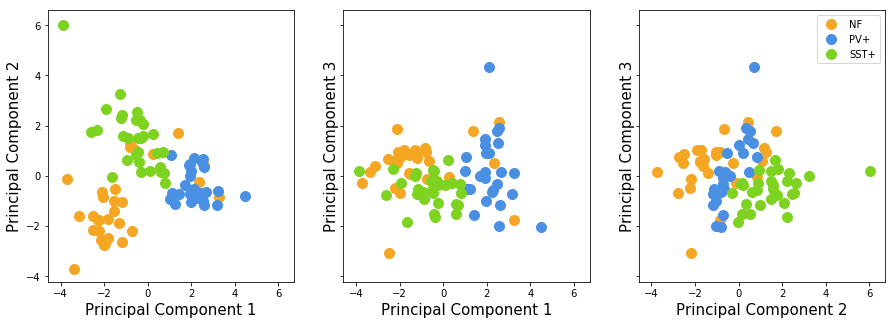

In [11]:
A.fig_pca

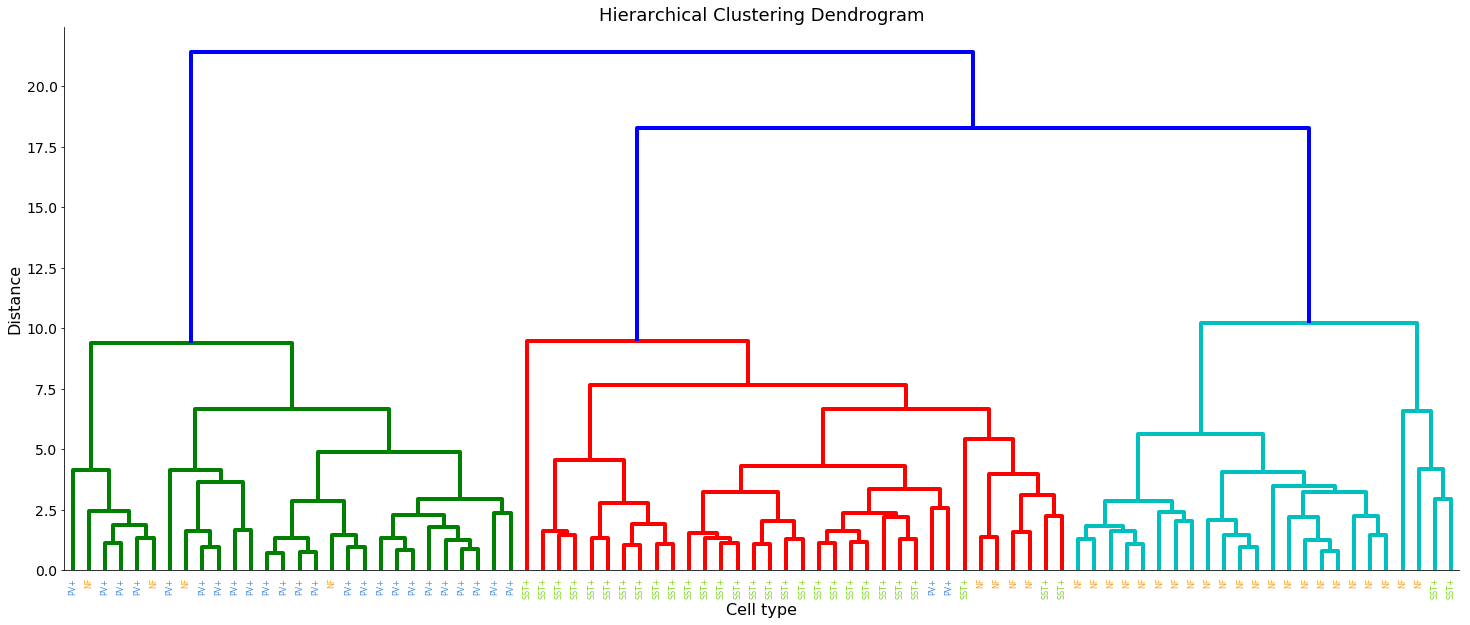

In [8]:
import matplotlib.pyplot as plt

ax = A.fig_dend.axes[0]
fluors = ['NF', 'PV+', 'SST+']
colors = ['#F5A623', '#4A90E2', '#7ED321']
for tl in ax.xaxis.get_ticklabels():
    color = [c for c,fl in zip(colors, fluors) if fl == tl.get_text()][0]
    tl.set_color(color)
    
ax.set_xlabel('Cell type', fontsize=16)
ax.set_ylabel('Distance', fontsize=16)
A.fig_dend

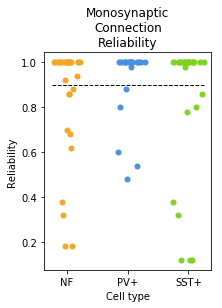

In [8]:
A.fig_monorel

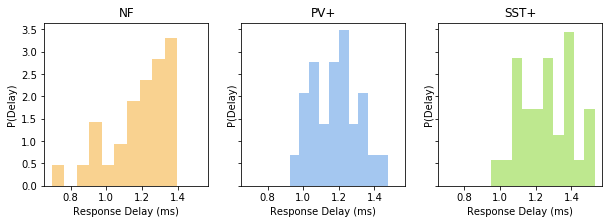

In [12]:
A.fig_mean_dly

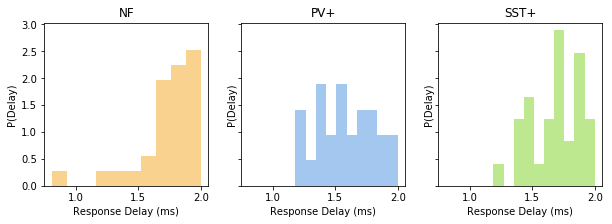

In [13]:
A.fig_max_dly

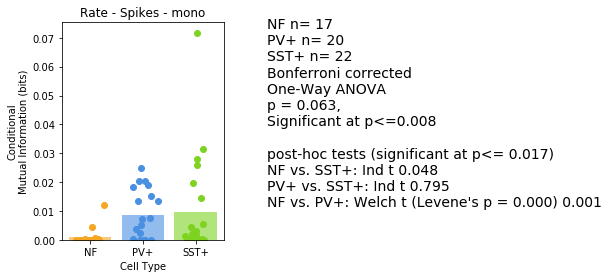

In [15]:
A.results['Rate']['Spikes']['mono']['fig']

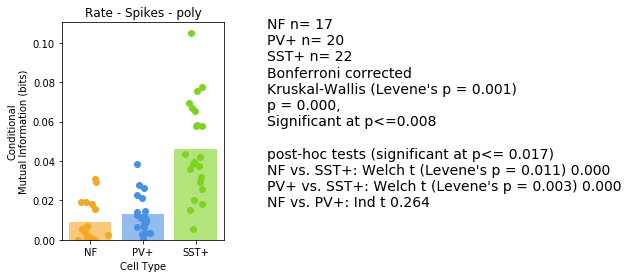

In [14]:
A.results['Rate']['Spikes']['poly']['fig']

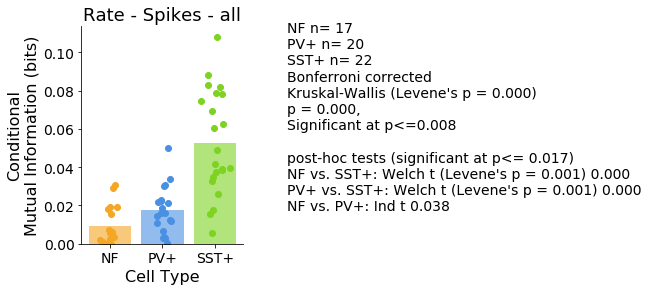

In [14]:
A.results['Rate']['Spikes']['all']['fig']

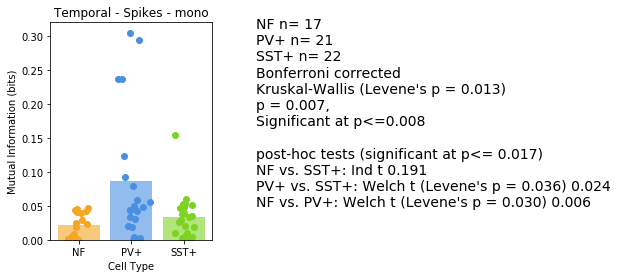

In [16]:
A.results['Temporal']['Spikes']['mono']['fig']

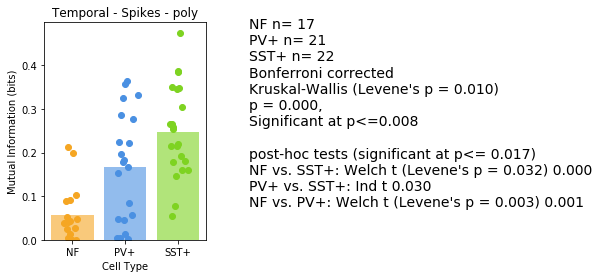

In [17]:
A.results['Temporal']['Spikes']['poly']['fig']

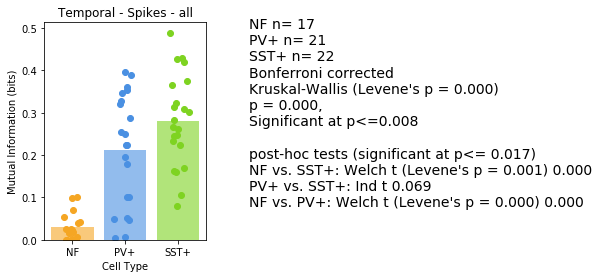

In [18]:
A.results['Temporal']['Spikes']['all']['fig']

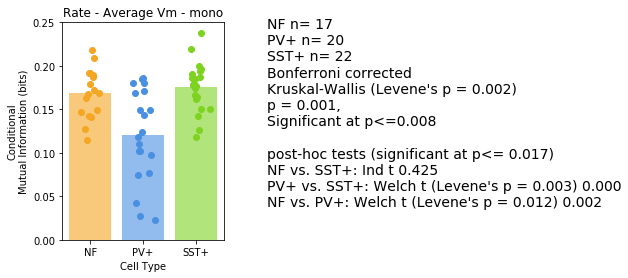

In [19]:
A.results['Rate']['Average Vm']['mono']['fig']

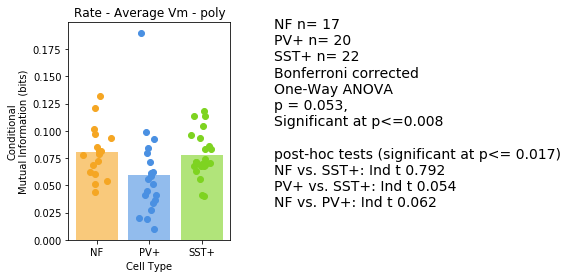

In [20]:
A.results['Rate']['Average Vm']['poly']['fig']

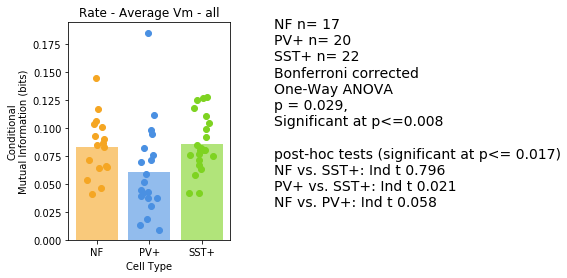

In [21]:
A.results['Rate']['Average Vm']['all']['fig']

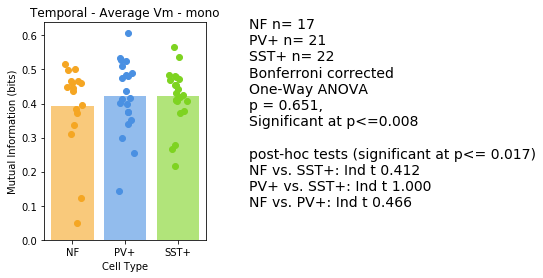

In [35]:
A.results['Temporal']['Average Vm']['mono']['fig']

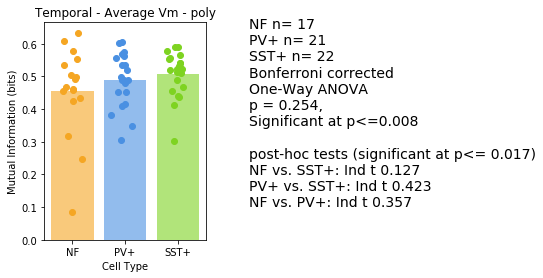

In [36]:
A.results['Temporal']['Average Vm']['poly']['fig']

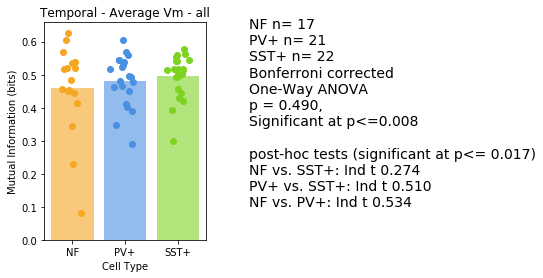

In [37]:
A.results['Temporal']['Average Vm']['all']['fig']

## Clustering

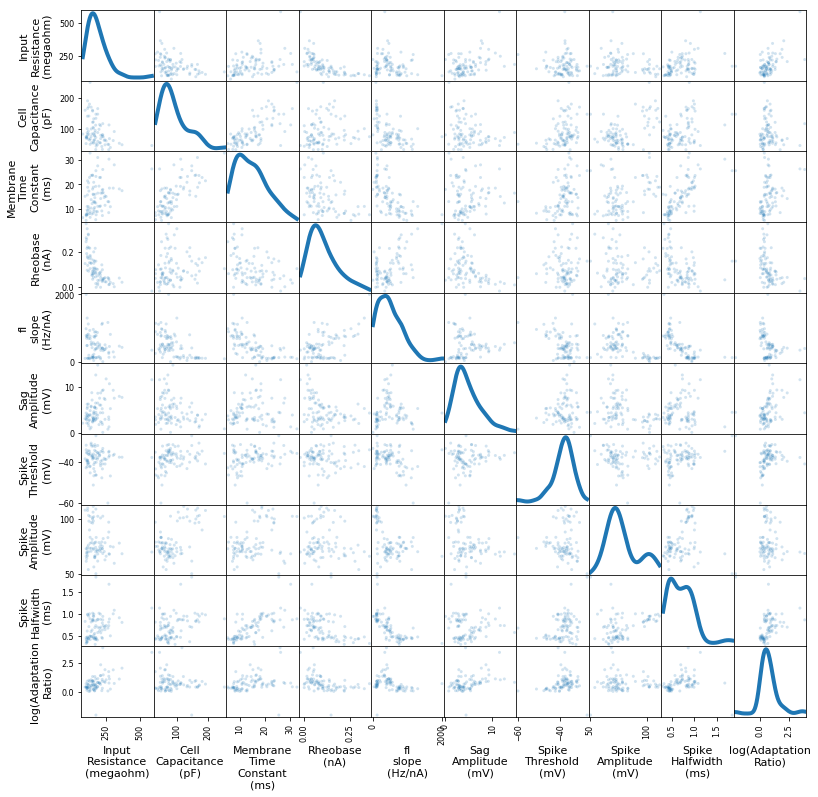

In [44]:
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt

df_ephys_transform = A.df_ephys.drop(['Adaptation Ratio', 'Vrest (mV)'], 1)
df_ephys_transform['log(Adaptation Ratio)'] = A.df_ephys['Adaptation Ratio'].apply(np.log)
axs = scatter_matrix(df_ephys_transform, alpha=0.2,figsize=(13,13), diagonal='kde')
for ax in np.ravel(axs):
    ax.set_xlabel(ax.get_xlabel().replace(' ', '\n'), fontsize=11)
    ax.set_ylabel(ax.get_ylabel().replace(' ', '\n'), fontsize=11)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.yaxis.set_label_coords(-0.4, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.4)

fig = plt.gcf()

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Imputer
import pandas as pd

features = df_ephys_transform.columns.values[2:]
x = df_ephys_transform.loc[:,features].values
y = df_ephys_transform.loc[:,['Fluorescence']].values

#standardize data, used Imputer to handle NaN entries
imp = Imputer(strategy="mean", axis=0)
scale = StandardScaler()
x = scale.fit_transform(imp.fit_transform(x))
pd.DataFrame(data = x, columns = features, index=df_ephys_transform.index).head()

,Input Resistance (megaohm),Cell Capacitance (pF),Membrane Time Constant (ms),Rheobase (nA),Sag Amplitude (mV),Spike Threshold (mV),Spike Amplitude (mV),Spike Halfwidth (ms),log(Adaptation Ratio),arctan(fI slope (Hz/nA))
17d05-1,-0.858880,-0.542614,-1.101405,2.353820,-0.984442,0.808000,-1.708926,-0.972217,-5.431782e-01,1.277792
17d05-2,0.587383,-0.216145,0.446154,-0.818597,-1.667379,1.043374,1.638398,0.903223,-1.563030e-16,-4.184908
17d05-4,-0.826613,1.933043,0.857387,-0.197778,-1.167644,0.443844,1.688444,0.923910,-2.392151e-01,-1.348418
17d06-1,0.549440,-1.325224,-1.189198,-0.098633,-1.050570,-1.036452,-0.256094,-0.942457,-6.345894e-01,1.297696
17d06-2,0.049991,-0.974453,-0.948539,-0.071882,-0.559508,-0.052460,-0.575576,-1.080820,-4.279582e-01,0.991157


In [37]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1', 'principal component 2', 'principal component 3'],
                           index = df_ephys_transform.index)
principalDf.head(8)

,principal component 1,principal component 2,principal component 3
17d05-1,-2.858747,-1.321992,-1.724482
17d05-2,3.512715,-0.985427,1.215268
17d05-4,2.616350,-2.218492,0.425487
17d06-1,-2.305505,0.267357,1.355954
17d06-2,-1.929220,0.179572,0.194986
17d07-1,2.441407,-2.418959,-0.812781
17d13-1,-2.400582,-1.114450,-0.269324
17d13-2,-2.412131,-1.397668,-1.933661


In [38]:
pca_components = pd.DataFrame(np.transpose(pca.components_), 
                columns = ['principal component 1', 'principal component 2', 'principal component 3'],
                index = features )
pca_components

,principal component 1,principal component 2,principal component 3
Input Resistance (megaohm),0.153905,0.515635,0.163978
Cell Capacitance (pF),0.354962,-0.359640,-0.164846
Membrane Time Constant (ms),0.469479,0.019906,-0.110676
Rheobase (nA),-0.262322,-0.396392,-0.283213
Sag Amplitude (mV),-0.021135,0.443244,-0.330374
Spike Threshold (mV),0.215522,-0.033979,-0.728955
Spike Amplitude (mV),0.287872,-0.268935,0.449904
Spike Halfwidth (ms),0.438571,0.070277,-0.033705
log(Adaptation Ratio),0.150133,0.394005,0.009553
arctan(fI slope (Hz/nA)),-0.465232,0.130886,-0.096513


In [39]:
#concatenate PCA values to fluorescent cell
finalDf = pd.concat([principalDf, df_ephys_transform[['Fluorescence']]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,principal component 3,Fluorescence
17d05-1,-2.858747,-1.321992,-1.724482,NF
17d05-2,3.512715,-0.985427,1.215268,NF
17d05-4,2.616350,-2.218492,0.425487,NF
17d06-1,-2.305505,0.267357,1.355954,PV+
17d06-2,-1.929220,0.179572,0.194986,PV+


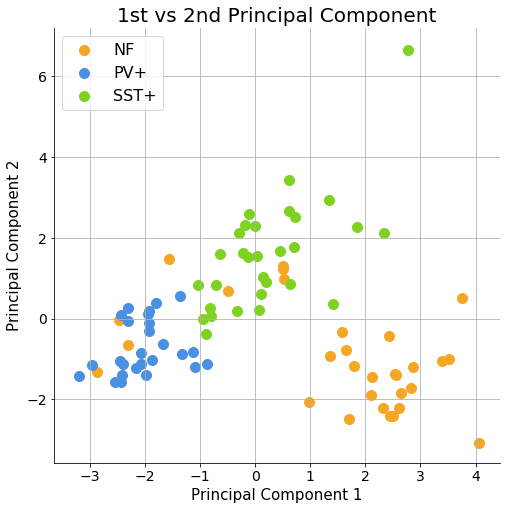

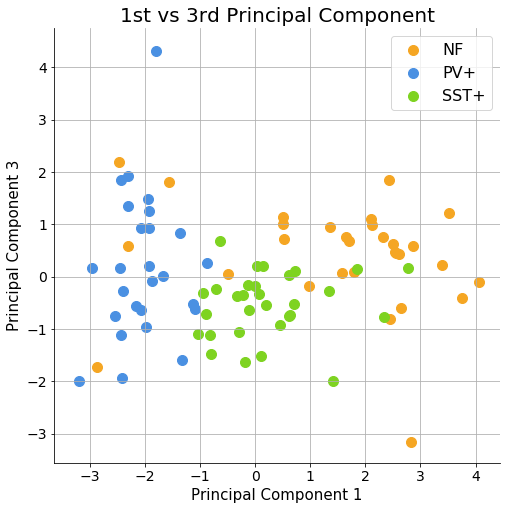

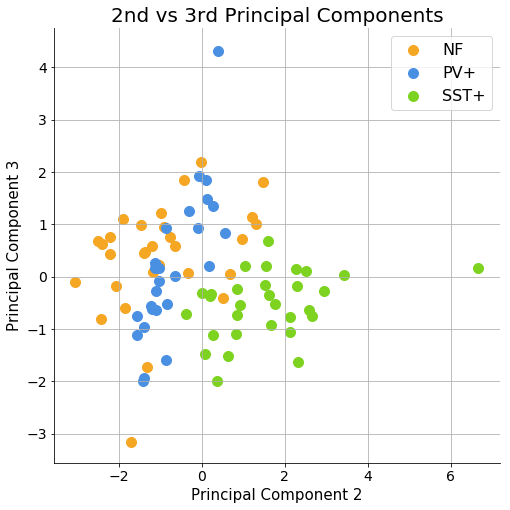

In [40]:
import matplotlib.pyplot as plt

#1st vs 2nd component PCA plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('1st vs 2nd Principal Component', fontsize = 20)


Fluorescence = ['NF', 'PV+', 'SST+']
colors = ['#F5A623', '#4A90E2', '#7ED321']
for target, color in zip(Fluorescence,colors):
    indicesToKeep = finalDf['Fluorescence'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 100)
ax.legend(Fluorescence)
ax.grid()

#1st vs 3nd component PCA plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('1st vs 3rd Principal Component', fontsize = 20)


Fluorescence = ['NF', 'PV+', 'SST+']
colors = ['#F5A623', '#4A90E2', '#7ED321']
for target, color in zip(Fluorescence,colors):
    indicesToKeep = finalDf['Fluorescence'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 100)
ax.legend(Fluorescence)
ax.grid()

#2nd vs 3rd component PCA plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2nd vs 3rd Principal Components', fontsize = 20)


Fluorescence = ['NF', 'PV+', 'SST+']
colors = ['#F5A623', '#4A90E2', '#7ED321']
for target, color in zip(Fluorescence,colors):
    indicesToKeep = finalDf['Fluorescence'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 100)
ax.legend(Fluorescence)
ax.grid()

In [41]:
pca.explained_variance_ratio_

array([0.35910039, 0.26476873, 0.12181729])

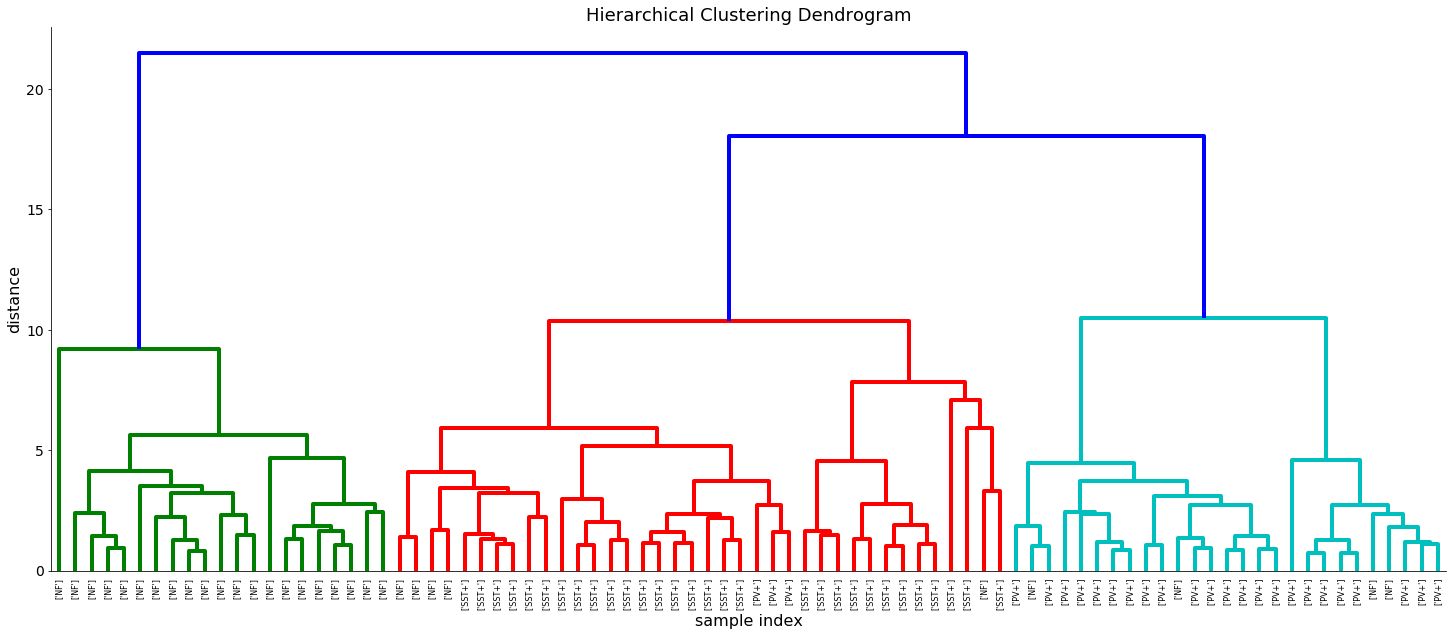

In [43]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#ward's linkage dendrogram
Z = linkage(x, 'ward')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=y
);

# dendrogram()

In [52]:
x

array([[-9.07871287e-01, -5.64860011e-01, -1.18055731e+00,
         2.47549260e+00,  1.91936763e+00, -9.95261947e-01,
         7.79185731e-01, -1.67710224e+00, -1.06222424e+00,
        -6.13921667e-01],
       [ 5.09734927e-01, -2.46969137e-01,  3.52693977e-01,
        -7.61354194e-01, -1.31536686e+00, -1.65136498e+00,
         1.04239849e+00,  1.56004181e+00,  8.00254302e-01,
         0.00000000e+00],
       [-8.76243401e-01,  1.84574642e+00,  7.60125189e-01,
        -1.27926936e-01, -1.02242930e+00, -1.17126595e+00,
         3.71958966e-01,  1.60844082e+00,  8.20797812e-01,
        -3.15937572e-01],
       [ 4.72543503e-01, -1.32690598e+00, -1.26753819e+00,
        -2.67682501e-02,  1.97733407e+00, -1.05879169e+00,
        -1.28342017e+00, -2.72091182e-01, -1.03266920e+00,
        -7.03534794e-01],
       [-1.70090828e-02, -9.85351896e-01, -1.02910477e+00,
         5.25851448e-04,  1.18857642e+00, -5.87024196e-01,
        -1.83045483e-01, -5.81057238e-01, -1.17007598e+00,
        -5.

# Electrophysiology analysis walkthrough

In [24]:
import ncstudy.cell as cell
from ncstudy.utils import merge_dicts
import re
import pandas as pd
import ncstudy.plots as plots

In [17]:
data_path = './data'
cell_ids = [os.path.basename(dirname[0])
                 for dirname in os.walk(data_path)
                 if re.match(r'\d{2}\w{1}\d{2}\-\d{1}', os.path.basename(dirname[0]))]
cell_ids.sort()
cells = cell.CellCollection(data_path= data_path)

for cell_id in cell_ids:
    celldir = '%s/%s'%(data_path, cell_id)
    neuron = cell.Cell(celldir)
    results = neuron.extract_ephys(pulse_on = 266, pulse_len = 500, sampling_frequency = 10.,
                                   I_min = -0.08, I_max = 0.4, I_step = 0.04)
    cells.add(neuron)

/home/luke/anaconda2/envs/data/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/luke/anaconda2/envs/data/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


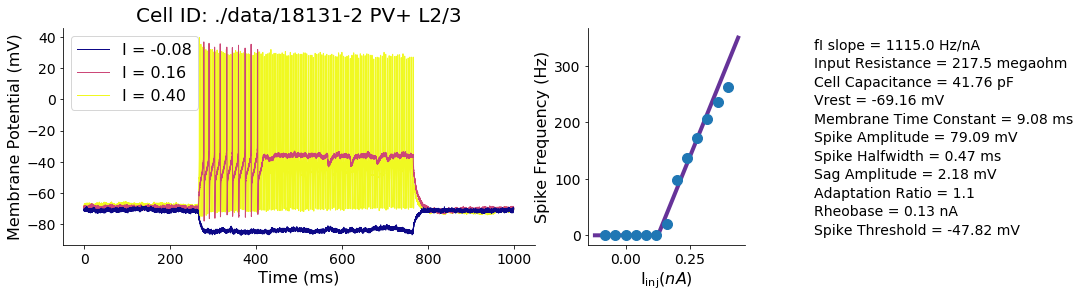

In [18]:
cells['18131-2'].ephys.plot()

## Table of electrophysiological properties and descriptive statistics

In [19]:
cells.collect_results()

In [22]:
df = pd.DataFrame(data=merge_dicts(cells.metadata,cells.ephys), index=cells.keys());

# Reorder columns

cols = ['Fluorescence','Layer',                                                # Cell Type
        'Vrest (mV)','Input Resistance (megaohm)',                             # Passive Properties
        'Cell Capacitance (pF)','Membrane Time Constant (ms)',                 # Passive Properties
        'Rheobase (nA)','fI slope (Hz/nA)',                                    # Active Properties
        'Adaptation Ratio','Sag Amplitude (mV)',                               # Slow Properties
        'Spike Threshold (mV)','Spike Amplitude (mV)','Spike Halfwidth (ms)']  # Action Potential Properties

df = df[cols]
cells.df_ephys = df[df['Layer']=='L2/3']
cells.df_ephys.groupby('Fluorescence').mean().round(2)

,Vrest (mV),Input Resistance (megaohm),Cell Capacitance (pF),Membrane Time Constant (ms),Rheobase (nA),fI slope (Hz/nA),Adaptation Ratio,Sag Amplitude (mV),Spike Threshold (mV),Spike Amplitude (mV),Spike Halfwidth (ms)
Fluorescence,,,,,,,,,,,
NF,-70.40,168.90,119.32,18.53,0.10,243.63,2.09,2.87,-37.77,90.99,0.90
PV+,-70.15,145.37,67.44,9.25,0.19,918.79,1.41,3.39,-40.56,72.13,0.43
SST+,-69.95,225.95,76.58,16.41,0.05,431.38,5.67,7.76,-36.79,71.29,0.72


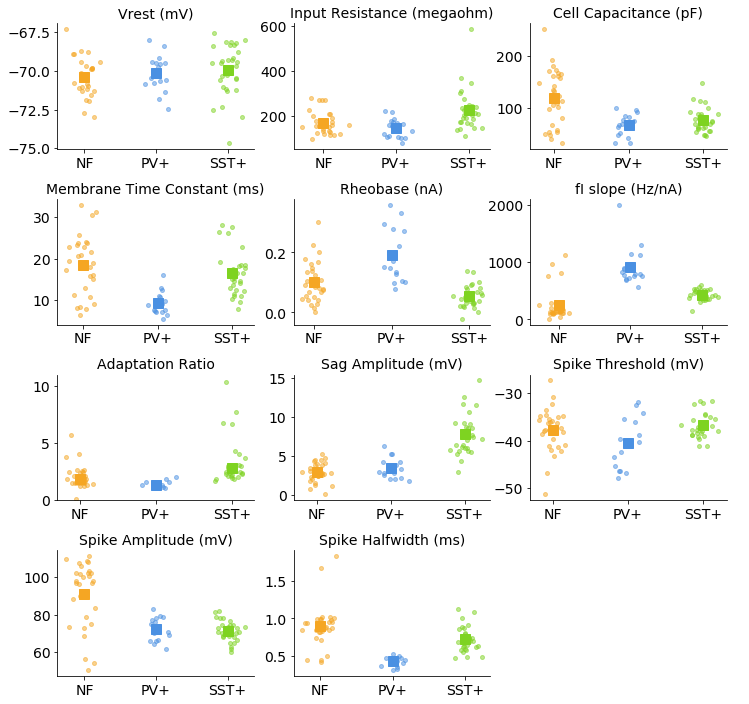

In [25]:
fig = plots.plot_ephys_summary(cells.df_ephys)
# fig.savefig('./figures/manuscript/ephys_features.svg')

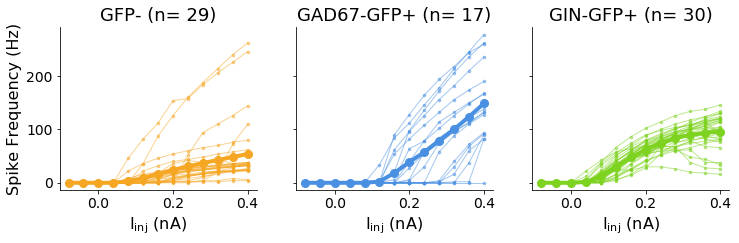

In [26]:
fig = plots.plot_fICurves(cells)

# Optogenetic Presynaptic Stimulation Walkthrough

In [27]:
import ncstudy.cell as cell
import ncstudy.synapses as syns

In [30]:
for cell_id, celln in cells.items():
    celln.syns = cell.Synapses(celln.celldir, mono_winsize=5, total_winsize=200, sampling_frequency=10)
    celln.syns.extract_features()

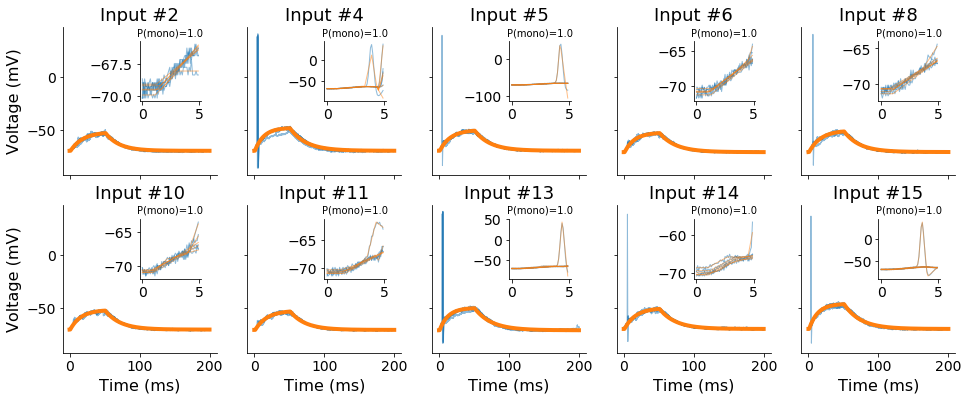

In [126]:
cells['18202-3'].syns.plot(savefig=False, figsize=(16,6))

In [128]:
cells.collect_results()
df = pd.DataFrame(data=merge_dicts(cells.metadata, cells.syns), index=cells.keys())
df_syns     = df[df['Layer']=='L2/3']

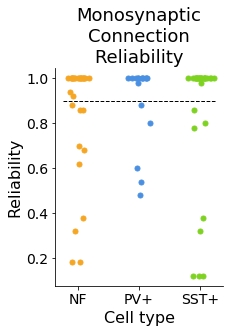

In [129]:
fig = plots.plot_syn_reliability(df_syns)

##  Rate and temporal code analysis

In [1]:
import ncstudy.cell as cell
import os
import re

data_path = './data'
cell_ids = [os.path.basename(dirname[0])
            for dirname in os.walk(data_path)
            if re.match(r'\d{2}\w{1}\d{2}\-\d{1}', os.path.basename(dirname[0]))]
cell_ids.sort()
cells = cell.CellCollection(data_path= data_path)

for cell_id in cell_ids:
    celldir = '%s/%s'%(data_path, cell_id)
    neuron = cell.Cell(celldir)


    neuron.rate_code = cell.Code(celldir=celldir, code_type='rate',
                                 stim_winsize=50, mono_winsize=5,
                                 start=5, dur=50, sampling_frequency=10)
    neuron.rate_code.estimate_mutual_information()
    
    neuron.temp_code = cell.Code(celldir=celldir, code_type='temp',
                                 stim_winsize=50, mono_winsize=5,
                                 start=5, dur=50, sampling_frequency=10)
    neuron.temp_code.estimate_mutual_information()
    
    cells.add(neuron)

In [4]:
cells.collect_metadata()
cells.collect_syns()
cells.collect_MI()

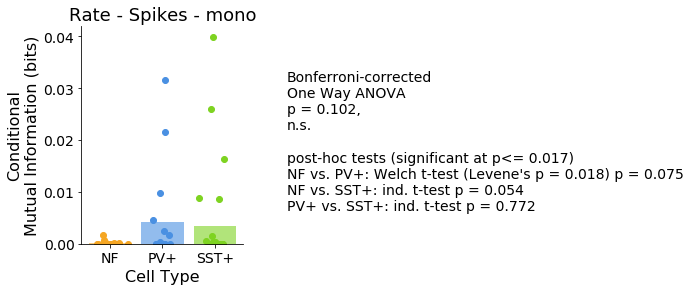

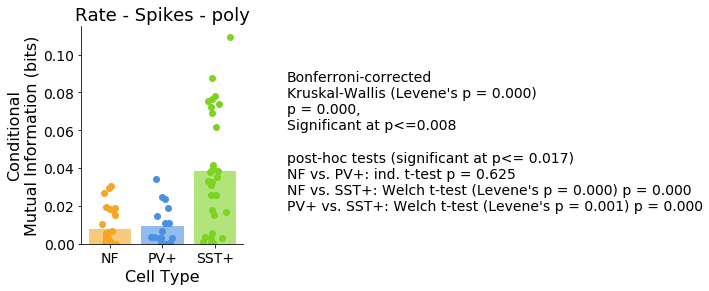

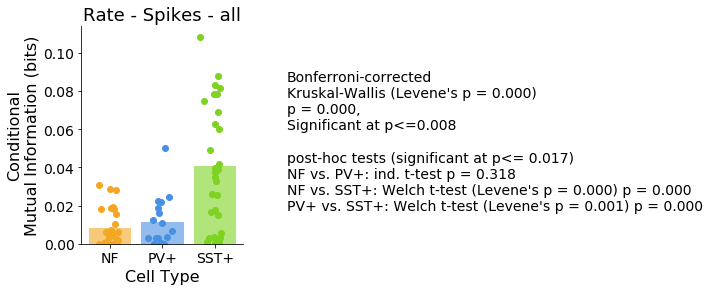

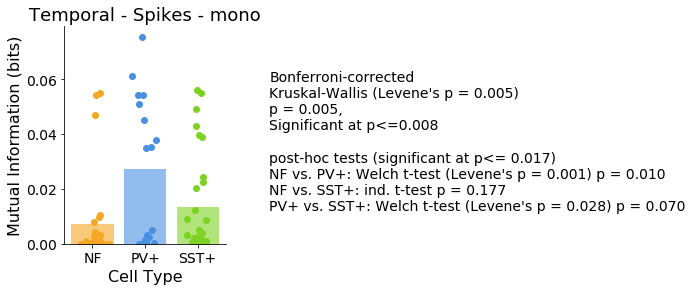

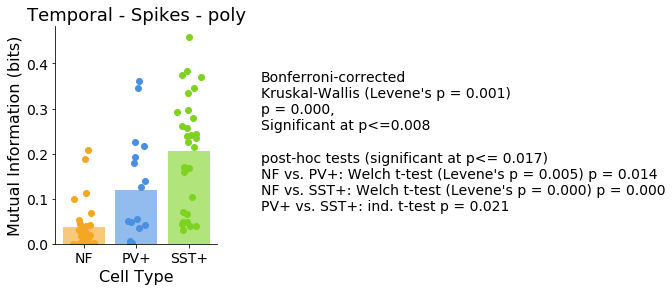

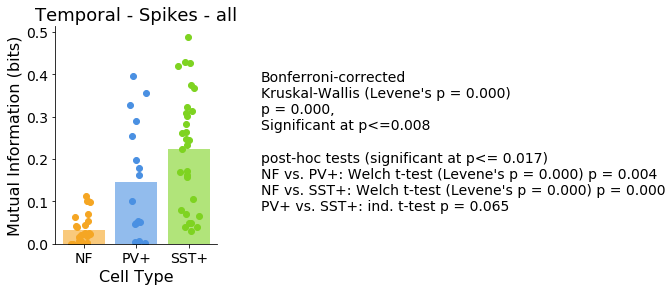

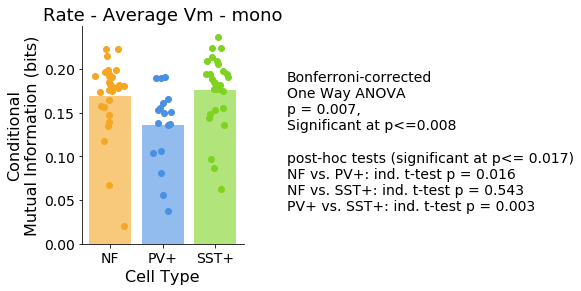

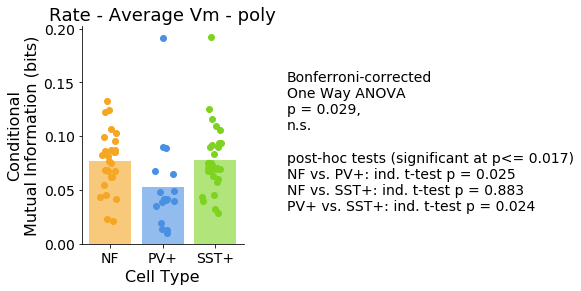

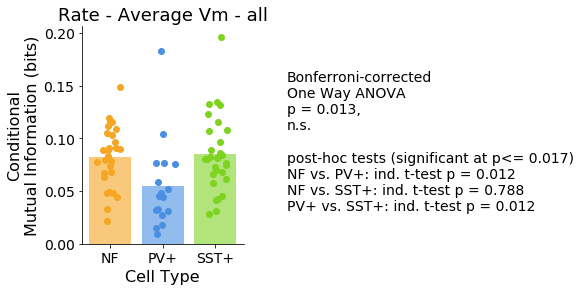

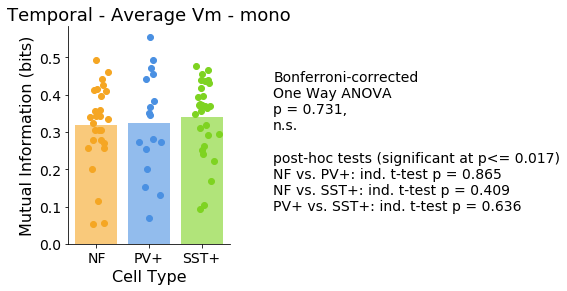

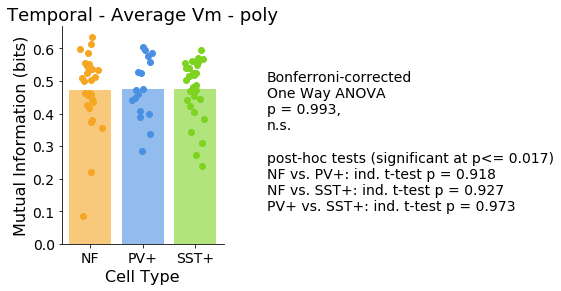

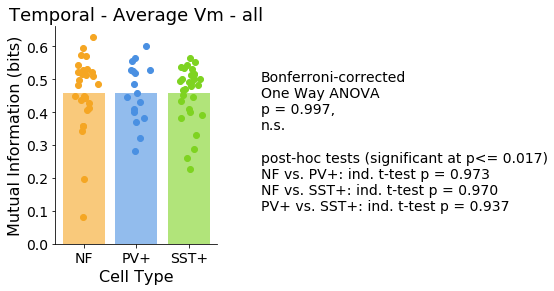

In [112]:
from ncstudy.utils import merge_dicts
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations

df_rate_spikes = pd.DataFrame(merge_dicts(cells.metadata, cells.MI['Rate']['Spikes']), index=cells.keys())
df_rate_spikes = df_rate_spikes[df_rate_spikes['Layer']=='L2/3']
df_rate_spikes = df_rate_spikes.dropna()[['Fluorescence', 'mono', 'poly', 'all']]
df_rate_spikes.head(10)

fluor_group_keys = ['NF', 'PV+', 'SST+']
fluor_group_pairs = list(combinations(range(len(fluor_group_keys)), 2))

colors = ['#F5A623', '#4A90E2', '#7ED321']
width = 0.8
alpha = 0.6
spread = 0.1

codes = ['Rate', 'Temporal']
resps = ['Spikes', 'Average Vm']
wins  = ['mono', 'poly', 'all']

figs = []
for resp in resps:
    for code in codes:
        for win in wins:
            df = pd.DataFrame(cells.metadata, index=cells.keys())
            df['MI'] = cells.MI[code][resp][win]
            df       = df[df['Layer']=='L2/3']
            df       = df.dropna()[['Fluorescence', 'MI']]
            
            fig = plt.figure(figsize=(3,4))
            plt.bar(x = np.arange(len(fluor_group_keys)),
                    height = df.groupby('Fluorescence').mean().squeeze(),
                    #yerr = df.groupby('Fluorescence').std().squeeze(),
                    width = width,
                    alpha=alpha,
                    color=colors)
            
            plt.xticks(range(len(fluor_group_keys)), fluor_group_keys)
            
            for fx, fl in enumerate(fluor_group_keys):
                vals = df[df['Fluorescence'] == fl]['MI']
                locs = np.random.randn(len(vals))*spread + fx
                plt.plot(locs, vals, 'o', color=colors[fx])
            plt.title('%s - %s - %s'%(code, resp, win))
            plt.xlabel('Cell Type')
            plt.ylabel('%sMutual Information (bits)'%('Conditional\n' if code == 'Rate' else ''))
            
            fig.set_size_inches((6,4))
            fig.subplots_adjust(right=0.5)
            ax_results = fig.add_axes([0.6,0.125,0.375,0.775])
            
            grouped_data = [df.groupby('Fluorescence').get_group(fl)['MI'] for fl in fluor_group_keys]
            _,p_levene = stats.levene(*grouped_data) # equal variances test

            test,test_string = (stats.f_oneway, 'One Way ANOVA') if p_levene > 0.05 else (stats.kruskal, 'Kruskal-Wallis (Levene\'s p = %.3f)'%p_levene)

            F, p_test = test(*grouped_data)

            result = 'Bonferroni-corrected\n%s\n'%test_string
            result += 'p = %.3f,\n%s\n\n'%(p_test, 'Significant at p<=%.3f'%(0.05/(len(wins)*len(codes))) if p_test<=0.05/(len(wins)*len(codes)) else 'n.s.')
            result += 'post-hoc tests (significant at p<= %.3f)'%(0.05/len(fluor_group_pairs))

            for pair in fluor_group_pairs:
                fl1 = pair[0]
                fl2 = pair[1]
                _, p_levene = stats.levene(grouped_data[fl1],grouped_data[fl2])
                test_string = 'ind. t-test' if p_levene > 0.05 else  'Welch t-test (Levene\'s p = %.3f)'%p_levene

                tstat, p_ttind = stats.ttest_ind(a = grouped_data[fl1], b = grouped_data[fl2], equal_var=p_levene>0.05)
                result += '\n%s vs. %s: %s p = %.3f'%(fluor_group_keys[fl1], fluor_group_keys[fl2], test_string, p_ttind)
                
            plt.sca(ax_results)
            plt.text(x=0.0, y=0.15, s=result, fontsize=14)
            plt.axis('off')

In [125]:
df[np.logical_and(df['Fluorescence']=='NF', df['MI']<=0.5)]

,Fluorescence,MI
17d05-1,NF,0.406142
17d05-2,NF,0.342212
17d05-4,NF,0.450190
17n29-2,NF,0.448169
18123-1,NF,0.486229
18201-2,NF,0.082163
18425-1,NF,0.358069
18529-1,NF,0.412190
18531-2,NF,0.482562
18601-1,NF,0.357919


In [116]:
df.

[{'Average Vm': {'all': [0.0894319197871889,
    0.07393981692800633,
    0.07904589774478499,
    0.08279403223522941,
    0.04773987652300615,
    0.05872019583104082,
    0.11943083552166378,
    0.113026103367452,
    0.05210507085416527,
    0.017886471062738885,
    0.02054275059762034,
    0.018064357422212574,
    0.009581200794543498,
    0.07704337739740641,
    0.019096488920554044,
    nan,
    0.14845213233108456,
    0.09647393729491505,
    0.1824815119976284,
    0.032831591384074876,
    0.08999886137813551,
    0.06807609151060312,
    0.04574074483991719,
    0.03170214743909838,
    0.044533052433441966,
    0.031287562786615375,
    0.057326463845889464,
    0.0816694110540297,
    0.0801031677804902,
    0.04499109416002689,
    0.06637314694630891,
    0.028399121743985845,
    0.08085585958618946,
    0.09683957703716395,
    0.07273444215516811,
    0.031041721745518558,
    0.06138535915323917,
    0.19639679737666693,
    0.08191370574782209,
    0.0862194633

In [105]:
df.groupby('Fluorescence').count()

,MI
Fluorescence,
NF,28
PV+,17
SST+,30


In [99]:
df[df['Fluorescence']== fl]['MI'].

AttributeError: 'Series' object has no attribute 'val'

## Bar Charts for Matt 

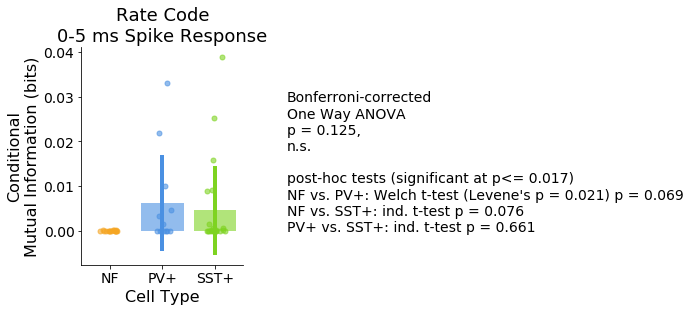

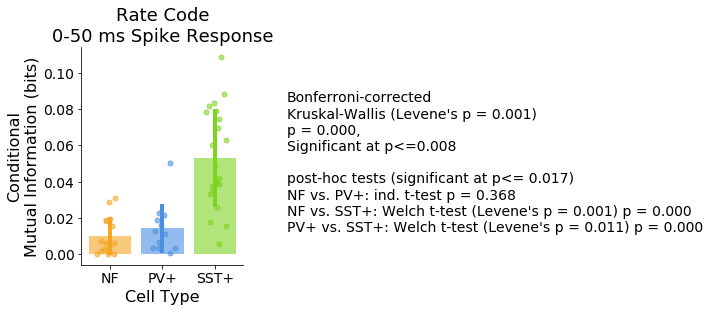

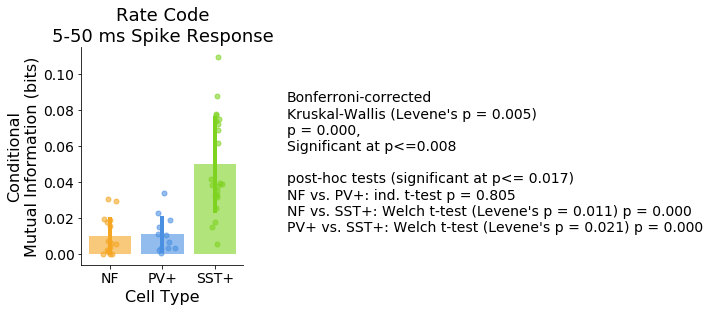

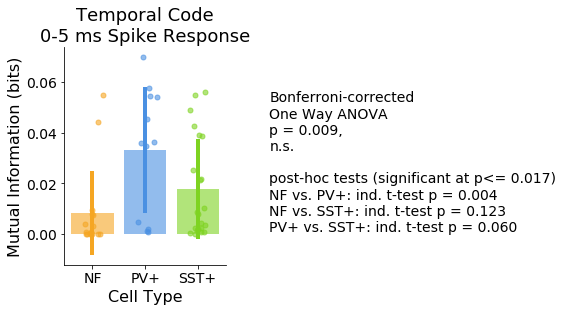

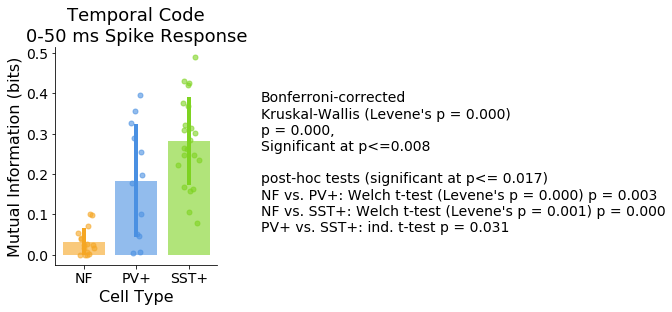

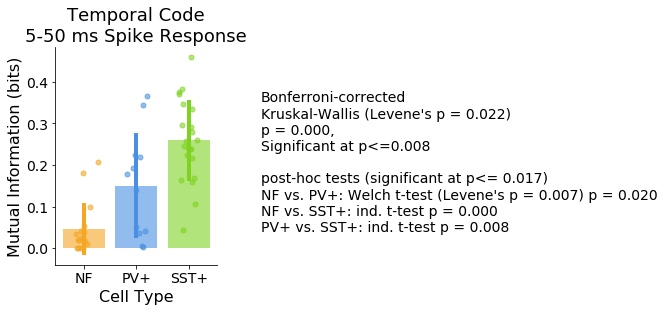

In [478]:
df_cols = [('Rate', 'MIc', 'Spikes', '0-5 ms'),
          ('Rate', 'MIc', 'Spikes', '0-50 ms'),
          ('Rate', 'MIc', 'Spikes', '5-50 ms'),
          ('Temp', 'MI', 'Spikes', '0-5 ms'),
          ('Temp', 'MI', 'Spikes', '0-50 ms'),
          ('Temp', 'MI', 'Spikes', '5-50 ms')
          ]

df_grouping = [('Fluorescence',np.nan,np.nan,np.nan)]

fluor_group_keys = ['NF', 'PV+', 'SST+']
fluor_group_pairs = list(combinations(range(len(fluor_group_keys)), 2))

colors = ['#F5A623', '#4A90E2', '#7ED321']

width = 0.8
alpha = 0.6
spread = 0.1

for col in df_cols:
    
    '''Figures'''
    
    df_bars = df_MI[df_grouping + [col]]
    df_bars_grouped = df_bars.groupby(df_grouping)
    means = df_bars_grouped.mean()
    stds = df_bars_grouped.std()
    
    conds_title = ('Temporal' if 'Temp' in col else 'Rate',
                   'V$_m$' if 'avVm' in col else col[-1] + ' Spike' if 'Spikes' in col else 'Slopes')
    
    conds_save = ('Temporal' if 'Temp' in col else 'Rate',
                   'avVm' if 'avVm' in col else col[-1] + 'Spike' if 'Spikes' in col else 'Slopes')
                 
    
    fig = plt.figure(figsize=(6,4))
    plt.bar(np.arange(3), means[col], yerr= stds[col], width=width, alpha = alpha, color = colors, ecolor = colors)

    for ix,fl in enumerate(fluor_group_keys):
        vals = df_bars_grouped.get_group(fl)[col]
        spread_vals = np.ones_like(vals)*ix + np.random.randn(len(vals))*spread
        plt.plot(spread_vals, vals, '.', color=colors[ix], ms = 10, zorder = -2, alpha=0.6)
    plt.xticks(range(3),fluor_group_keys)
    plt.xlabel('Cell Type')
    plt.ylabel('%sMutual Information (bits)'%('Conditional\n' if 'MIc' in col else ''))
    title_string = '%s Code\n%s Response'%conds_title

    plt.title(title_string)
    
    '''Stats'''
    
    grouped_data = [df_bars.groupby(df_grouping).get_group(fl)[col] for fl in fluor_group_keys]
    _,p_levene = stats.levene(*grouped_data) # equal variances test
    
    test,test_string = (stats.f_oneway, 'One Way ANOVA') if p_levene > 0.05 else (stats.kruskal, 'Kruskal-Wallis (Levene\'s p = %.3f)'%p_levene)
    
    F, p_test = test(*grouped_data)
    
    result = 'Bonferroni-corrected\n%s\n'%test_string
    result += 'p = %.3f,\n%s\n\n'%(p_test, 'Significant at p<=%.3f'%(0.05/len(df_cols)) if p_test<=0.05/len(df_cols) else 'n.s.')
    result += 'post-hoc tests (significant at p<= %.3f)'%(0.05/len(fluor_group_pairs) )
    
    for pair in fluor_group_pairs:
        fl1 = pair[0]
        fl2 = pair[1]
        _, p_levene = stats.levene(grouped_data[fl1],grouped_data[fl2])
        test_string = 'ind. t-test' if p_levene > 0.05 else  'Welch t-test (Levene\'s p = %.3f)'%p_levene

        tstat, p_ttind = stats.ttest_ind(a = grouped_data[fl1], b = grouped_data[fl2], equal_var=p_levene>0.05)
        result += '\n%s vs. %s: %s p = %.3f'%(fluor_group_keys[fl1], fluor_group_keys[fl2], test_string, p_ttind)
    
    fig.subplots_adjust(right=0.5)
    ax_results = fig.add_axes([0.6,0.125,0.375,0.775])
    plt.sca(ax_results)
    plt.text(x=0.0, y=0.15, s=result, fontsize=14)
    plt.axis('off')
    
    fig.savefig('./figures/manuscript/MI_%s_%s_'%conds_save+'.svg')

In [479]:
df_MI.loc['18d27-1']['Temp','MI', 'Spikes']

0-10 ms     0.00273225
0-15 ms      0.0281699
0-20 ms      0.0786501
0-5 ms       0.0441105
0-50 ms       0.101983
0-8 ms       0.0268966
10-50 ms      0.180527
5-50 ms       0.180527
Name: 18d27-1, dtype: object

### Extreme example traces

In [144]:
'''Extreme MI traces'''

minMI_celldirs = np.array(df_bars.groupby(df_grouping).idxmin())
maxMI_celldirs = np.array(df_bars.groupby(df_grouping).idxmax())

for ii,fl in enumerate(fluor_group_keys):
    for jj,col in enumerate(df_cols):
        min_celldir = minMI_celldirs[ii,jj]
        max_celldir = maxMI_celldirs[ii,jj]
        newdir = './figures/FENS_poster/extreme_MI/'

        fileType = col[0] if col[0] is 'Rate' else 'Temporal'
        respType = col[2]
        
        min_filename = './%s/%s_1.svg'%(min_celldir,fileType)
        min_newfilename = '%s%s_example_%s_%s_lowMI.svg'%(newdir, fl,fileType, respType)
        
        max_filename = './%s/%s_1.svg'%(max_celldir,fileType)
        max_newfilename = '%s%s_example_%s_%s_highMI.svg'%(newdir, fl,fileType, respType)
        
        os.system('cp %s %s'%(min_filename, newdir))
        os.system('mv %s%s_1.svg %s'%(newdir,fileType,min_newfilename))
        
        os.system('cp %s %s'%(max_filename, newdir))
        os.system('mv %s%s_1.svg %s'%(newdir,fileType,max_newfilename))

IndexError: index 1 is out of bounds for axis 1 with size 1

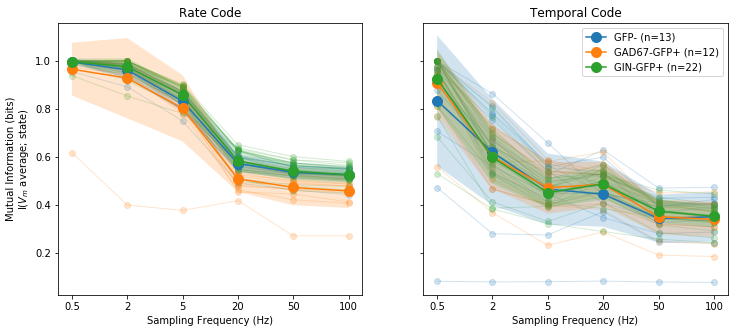

In [145]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True,sharey=True)
for MItype,ax,title in zip(MI_avVm,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for fluorLabel,fluorType,color in zip(['GFP-','GAD67-GFP+','GIN-GFP+'],['NF','PV+','SST+'],['C0','C1','C2']):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorType])
        plt.plot(MI_bycell.T,'-o',color=color,zorder=-2,lw=1,alpha=0.2)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.fill_between(range(6),avMI+sdMI,avMI-sdMI,alpha=0.2)
        plt.plot(range(6),avMI,'-o',ms=10,label=fluorLabel+' (n=%i)'%len(MI_bycell))
        
    plt.title(title)
    plt.xticks(range(6),sampling_freqs)
    plt.xlabel('Sampling Frequency (Hz)')

plt.legend()
plt.sca(axs[0])
plt.ylabel('Mutual Information (bits)\nI($V_m$ average; state)')

fig.savefig('./figures/svg/MI_avVm'+(time.strftime("%d-%m-%Y-%H-%M-%S"))+'.svg')

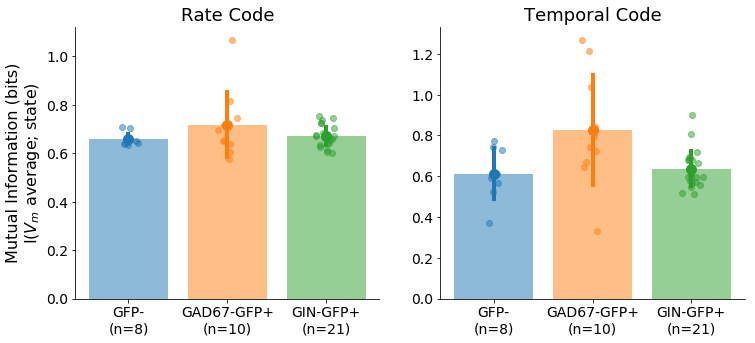

In [370]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

view_win = 20

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MI_avVm,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        MI_bycell = MI_bycell[:, np.array(sampling_freqs)==view_win].squeeze()
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Mutual Information (bits)\nI($V_m$ average; state)')
fig.savefig('./figures/svg/MI_avVm_bar.svg')

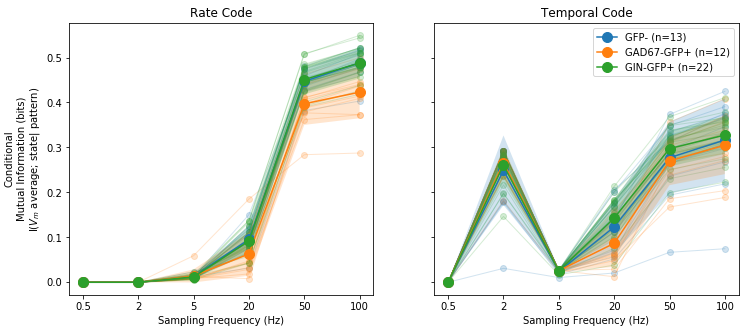

In [124]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True,sharey=True)
for MItype,ax,title in zip(MIc_avVm,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for fluorLabel,fluorType,color in zip(['GFP-','GAD67-GFP+','GIN-GFP+'],['NF','PV+','SST+'],['C0','C1','C2']):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorType])
        plt.plot(MI_bycell.T,'-o',color=color,zorder=-2,lw=1,alpha=0.2)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.fill_between(range(6),avMI+sdMI,avMI-sdMI,alpha=0.2)
        plt.plot(range(6),avMI,'-o',ms=10,label=fluorLabel+' (n=%i)'%len(MI_bycell))
        
    plt.title(title)
    plt.xticks(range(6),sampling_freqs)
    plt.xlabel('Sampling Frequency (Hz)')

plt.legend()
plt.sca(axs[0])
plt.ylabel('Conditional\nMutual Information (bits)\nI($V_m$ average; state| pattern)')

fig.savefig('./figures/svg/MIc_avVm')

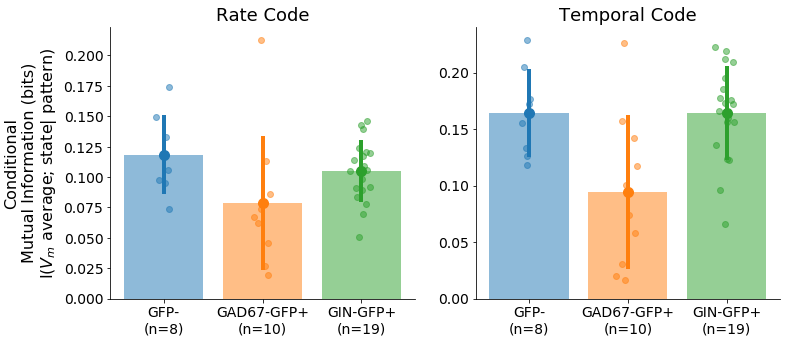

In [165]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

view_win = 20

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MIc_avVm,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        MI_bycell = MI_bycell[:, np.array(sampling_freqs)==view_win].squeeze()
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Conditional\nMutual Information (bits)\nI($V_m$ average; state| pattern)')
fig.savefig('./figures/svg/MIc_avVm_bar.svg')

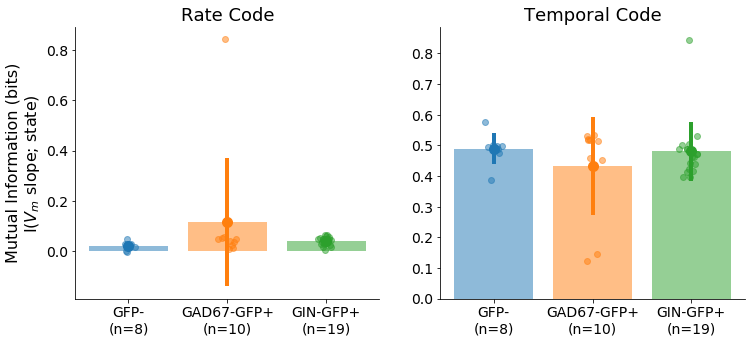

In [117]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MI_slope,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Mutual Information (bits)\nI($V_m$ slope; state)')
fig.savefig('./figures/svg/MI_slopes.svg')

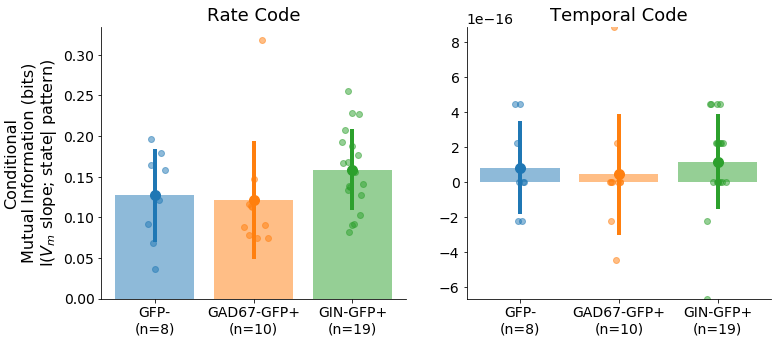

In [167]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MIc_slope,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Conditional\nMutual Information (bits)\nI($V_m$ slope; state| pattern)')
fig.savefig('./figures/svg/MIc_slopes.svg')

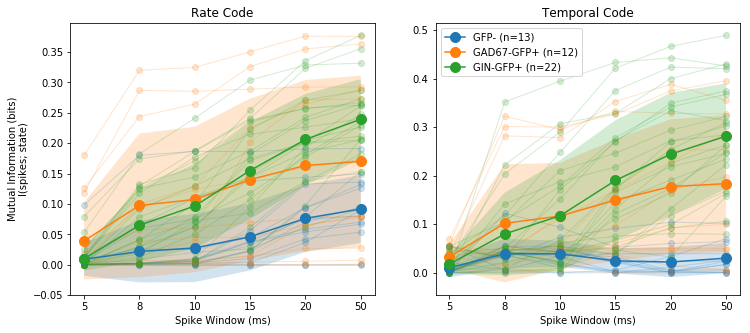

In [146]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

sptw = [int(win*1000) for win in spTimeWins]

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MI_spike,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        avMI = np.nanmean(MI_bycell,axis=0)
        sdMI = np.nanstd(MI_bycell,axis=0,ddof=1)
        plt.plot(range(len(spTimeWins)),avMI,'-o',ms=10,label=fluorLabels[ix]+' (n=%i)'%len(MI_bycell))
        plt.fill_between(range(len(spTimeWins)),avMI+sdMI,avMI-sdMI,alpha=0.2,zorder=-2)
        plt.plot(range(len(spTimeWins)),MI_bycell.T,'-o',color=colors[ix],alpha=0.2,lw=1,zorder=-1)
    plt.title(title)
    plt.xlabel('Spike Window (ms)')
        
plt.xticks(range(len(sptw)),sptw)
plt.legend()

plt.sca(axs[0])
plt.ylabel('Mutual Information (bits)\nI(spikes; state)')

fig.savefig('./figures/svg/MI_spikes'+(time.strftime("%d-%m-%Y-%H-%M-%S"))+'.svg')

In [22]:
from ncstudy.utils import hcf

In [32]:
hcf(20, 8)

4

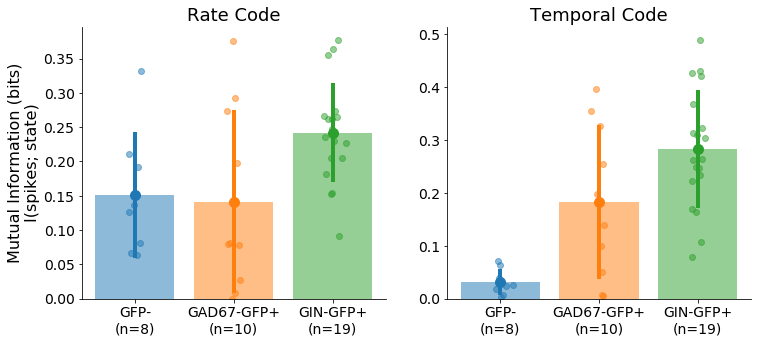

In [168]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

view_win = 0.05

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MI_spike,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        MI_bycell = MI_bycell[:, np.array(spTimeWins)==view_win].squeeze()
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Mutual Information (bits)\nI(spikes; state)')
fig.savefig('./figures/svg/MI_spikes_bar.svg')

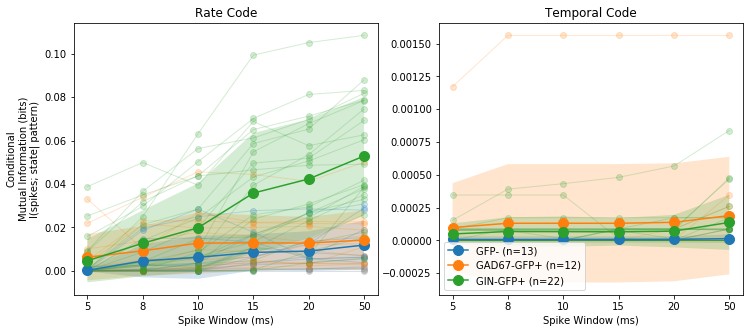

In [148]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

sptw = [int(win*1000) for win in spTimeWins]

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MIc_spike,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        avMI = np.nanmean(MI_bycell,axis=0)
        sdMI = np.nanstd(MI_bycell,axis=0,ddof=1)
        plt.plot(range(len(spTimeWins)),avMI,'-o',ms=10,label=fluorLabels[ix]+' (n=%i)'%len(MI_bycell))
        plt.fill_between(range(len(spTimeWins)),avMI+sdMI,avMI-sdMI,alpha=0.2,zorder=-2)
        plt.plot(range(len(spTimeWins)),MI_bycell.T,'-o',color=colors[ix],alpha=0.2,lw=1,zorder=-1)
    plt.title(title)
    plt.xlabel('Spike Window (ms)')
        
plt.xticks(range(len(sptw)),sptw)
plt.legend()

plt.sca(axs[0])
plt.ylabel('Conditional\nMutual Information (bits)\nI(spikes; state| pattern)')

fig.savefig('./figures/svg/MIc_spikes'+(time.strftime("%d-%m-%Y-%H-%M-%S"))+'.svg')

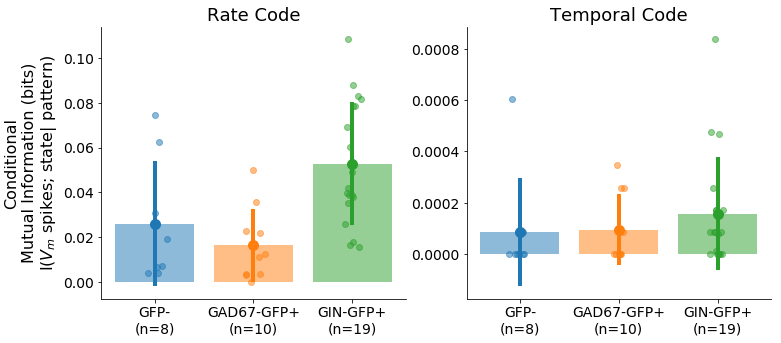

In [208]:
fluorLabels = ['GFP-','GAD67-GFP+','GIN-GFP+']
fluorTypes = ['NF','PV+','SST+']
colors = ['C0','C1','C2']

view_win = 0.05

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5),sharex=True)
for MItype,ax,title in zip(MIc_spike,axs,['Rate Code','Temporal Code']):
    plt.sca(ax)
    for ix in range(3):
        MI_bycell = np.array([mi for mi,fl in zip(MItype,fluors) if fl==fluorTypes[ix]])
        MI_bycell = MI_bycell[:, np.array(spTimeWins)==view_win].squeeze()
        if '\n(n=%i)'%len(MI_bycell) not in fluorLabels[ix]:
            fluorLabels[ix] = fluorLabels[ix] +'\n(n=%i)'%len(MI_bycell)
        avMI = MI_bycell.mean(axis=0)
        sdMI = MI_bycell.std(axis=0,ddof=1)
        plt.bar(ix,avMI,alpha=0.5)
        plt.errorbar(ix,avMI,sdMI,fmt='o',ms=10)
        plt.plot(np.ones_like(MI_bycell)*ix+np.random.randn(len(MI_bycell))*0.05,MI_bycell,
                 'o',color=colors[ix],alpha=0.5)
        
    plt.title(title)
    plt.xticks(range(3),fluorLabels)

plt.sca(axs[0])
plt.ylabel('Conditional\nMutual Information (bits)\nI($V_m$ spikes; state| pattern)')
fig.savefig('./figures/svg/MIc_spikes_bar.svg')

In [151]:
def plot_fullJointProb(pxyz,fileType,celldir,win):

    fig,axs = plt.subplots(ncols=2,figsize=(9,10),sharex=True,sharey=True)
    
    pxy0,pxy1 = pxyz

    srtp = np.ravel(pxyz)
    srtp = np.sort(srtp)
    vmax = (srtp[-3]+0.05).round(2)

    plt.sca(axs[0])
    plt.imshow(pxy0,vmin=0,vmax=vmax)
    plt.title('Low')
    plt.ylabel('Input Spike Count (Pattern)')
    plt.xlabel('Output Spike Count (Response)')

    plt.sca(axs[1])
    plt.title('High')
    plt.xlabel('Output Spike Count (Response)')
    im = plt.imshow(pxy1,vmin=0,vmax=vmax)

    plt.xlim((-0.5,5.5))
    plt.ylim((-0.5,10.5))
    plt.xticks(range(6))

    fig.text(x=0.5,y=0.975,s='%s Code (State)'%fileType,fontsize=20,horizontalalignment='center')

    fig.subplots_adjust(bottom=0.3)
    cax = fig.add_axes([0.125,0.1,0.775,0.05])

    fig.colorbar(mappable=im,cax=cax,orientation='horizontal',extend='max')
    cax.set_xlabel('P (state, pattern, response)')
    
    fig.savefig('%s/%s_joint_spikes_%i'%(celldir,fileType,int(win*1000)))
    plt.close()

In [122]:
plot_fullJointProb(prsc,fileType=fileType)

TypeError: plot_fullJointProb() takes exactly 4 arguments (2 given)

## 4. Power Spectrum

In [4]:
sampling_frequency = 10000

celldirs = [x[0][2:] for x in os.walk('./') if x[0].startswith('./1')]
celldirs.sort()

ff_rsq = []
rc_rsq = []
tc_rsq = []

ff_logp = []
rc_logp = []
tc_logp = []

for celldir in celldirs:
    try:
        data_ff = load_episodic('./%s/Full_field.abf'%celldir)
        data_rc = load_episodic('./%s/Rate.abf'%celldir)
        data_tc = load_episodic('./%s/Temporal.abf'%celldir)
    except IOError:
        continue

    Vm_ff = data_ff[0][6*sampling_frequency:-6*sampling_frequency,:,0]
    Vm_rc = data_rc[0][6*sampling_frequency:-6*sampling_frequency,:,0]
    Vm_tc = data_tc[0][6*sampling_frequency:-6*sampling_frequency,:,0]

    for Vm,rsq, all_logp in zip([Vm_ff, Vm_rc, Vm_tc],[ff_rsq, rc_rsq, tc_rsq], [ff_logp, rc_logp, tc_logp]):
        f,p = sig.periodogram(Vm.T,fs=sampling_frequency)
        p = p.mean(axis=0)
        logf = np.log10(f[f<200][1:])
        logp = np.log10(p[f<200][1:])
        all_logp.append(logp)
        slope, intercept, rval, pval, stderr = stats.linregress(logf, logp)
        rsq.append(rval**2)
        
Rsq = np.array([ff_rsq, rc_rsq, tc_rsq])

ff_logp = np.mean(ff_logp, axis=0)
rc_logp = np.mean(rc_logp, axis=0)
tc_logp = np.mean(tc_logp, axis=0)

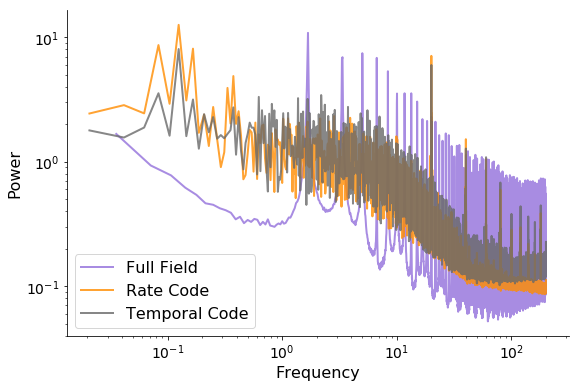

In [33]:
colors = ['mediumpurple', 'darkorange', 'dimgrey']

fig = plt.figure(figsize=(9,6))

ff_f = np.linspace(0,200,len(ff_logp)+1)[1:]
rc_f = np.linspace(0,200,len(rc_logp)+1)[1:]
tc_f = np.linspace(0,200,len(rc_logp)+1)[1:]

plt.loglog(ff_f, np.exp(ff_logp), colors[0], alpha=0.8, lw=2)
plt.loglog(rc_f, np.exp(rc_logp), colors[1], alpha=0.8, lw=2)
plt.loglog(tc_f, np.exp(tc_logp), colors[2], alpha=0.8, lw=2)

plt.legend(['Full Field', 'Rate Code', 'Temporal Code'])
plt.xlabel('Frequency')
plt.ylabel('Power')

fig.savefig('./figures/FENS_poster/power_spectrum_opto')

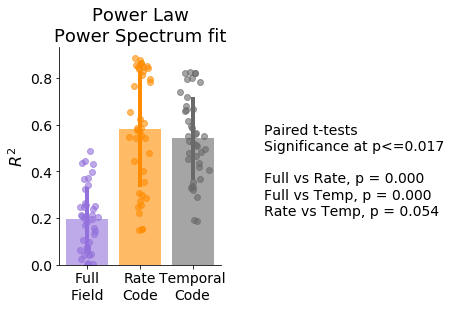

In [35]:
colors = ['mediumpurple', 'darkorange', 'dimgrey']

fig = plt.figure(figsize=(6,4))
plt.bar(range(3), Rsq.mean(axis=1), yerr=Rsq.std(axis=1, ddof=1), color=colors, alpha=0.6, ecolor=colors)
for ix,group in enumerate(Rsq):
    plt.plot(np.random.randn(len(group))*0.1+ix, group, 'o',alpha=0.6,zorder=-2, color= colors[ix])

pair_combos = list(combinations(range(3),2))
results_string = 'Paired t-tests\nSignificance at p<=%.3f\n\n'%(0.05/len(pair_combos))
dataTypes = ['Full\nField', 'Rate\nCode', 'Temporal\nCode']

for pair in pair_combos:
    ix1,ix2 = pair
    _,p_test = stats.ttest_rel(Rsq[ix1],Rsq[ix2])
    results_string += '%s vs %s, p = %.3f\n'%(dataTypes[ix1][:4], dataTypes[ix2][:4], p_test)
    
plt.xticks(range(3),dataTypes)
plt.ylabel('$R^2$')
plt.title('Power Law\nPower Spectrum fit')

fig.subplots_adjust(right=0.5)
ax_results = fig.add_axes([0.6,0.125,0.375,0.775])
plt.sca(ax_results)
plt.text(x=0.0, y=0.15, s=results_string, fontsize=14)
plt.axis('off')

fig.savefig('./figures/svg/power_spectrum_rsq')